In [1]:
#####Joint Embedding with Factorization Machinese#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [3]:
####データの発生####
##データの設定
s = 2
type_n = 2
k1 = 10
k2 = 10
k3 = 7
hh = 5000   #company数
item = 4000   #item数
element = 500   #element数
pt1 = np.random.poisson(30.0, hh)   #companyあたりのレコード数
hhpt = np.sum(pt1)
vec_k1 = np.repeat(1, k1); vec_k2 = np.repeat(1, k2); vec_k3 = np.repeat(1, k3)

In [4]:
##IDとインデックスを作成
#IDの作成
d_id = np.repeat(np.arange(hh), pt1)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt1[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
d_list1 = [i for i in range(hh)]
for i in range(hh):
    d_list1[i] = np.array(np.where(d_id==i)[0], dtype="int")
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(hh, hhpt)).tocsr() 

In [5]:
##観測単位でのidを作成
#レコードごとの頻度を生成
gamma = np.random.gamma(2.0, 1/0.5, hh)[d_id]
freq = np.random.poisson(gamma, hhpt)
freq[freq < 1] = 1
max_freq = np.max(freq)
N = np.sum(freq)

#観測単位でのidを作成
d_long = np.repeat(d_id, freq)
record_id = np.repeat(np.arange(hhpt), freq)
record_dt = sparse.coo_matrix((np.repeat(1, N), (record_id, range(N))), shape=(hhpt, N)).tocsr()
m = pt1[d_long]
M = np.sum(m)

#インデックスの設定
d_list2 = [i for i in range(hh)]
record_list = [i for i in range(hhpt)]
pt2 = np.repeat(0, hh)
for i in range(hh):
    d_list2[i] = np.array(np.where(d_long==i)[0], dtype="int")
    pt2[i] = d_list2[i].shape[0]
for i in range(hhpt):
    record_list[i] = np.array(np.where(record_id==i)[0], dtype="int")

In [6]:
##itemとelementを生成
#トピックのパラメータを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.5, topic), hh)
phi_item = np.random.dirichlet(np.repeat(0.5, item), topic)
phi_element = np.random.dirichlet(np.repeat(0.5, element), topic)

#トピックとアイテムの格納用配列
z = np.repeat(0, N)
item_long = np.repeat(0, N)
element_long = np.repeat(0, N)

#多項分布からアイテムを生成
for i in range(hh):
    index = d_list2[i]
    z[index, ] = np.array(rmnom(theta_topic[d_long[index], ], pt2[i], topic, 0), dtype="int16")
    item_long[index, ] = np.array(rmnom(phi_item[z[index], ], pt2[i], item, 0), dtype="int16")
    element_long[index] = np.array(rmnom(phi_element[z[index], ], pt2[i], element, 0), dtype="int")

In [7]:
##trendを生成
#ベルヌーイ分布からtrendを生成
pi = 0.55
greater = np.random.binomial(1, pi, N)
lesser = 1 - greater

#インデックスを定義
index_greater = np.array(np.where(greater==1)[0], dtype="int")
index_lesser = np.array(np.where(lesser==1)[0], dtype="int")
d_long1 = d_long[index_greater]; d_long2 = d_long[index_lesser]
item_long1 = item_long[index_greater]; item_long2 = item_long[index_lesser]
element_long1 = element_long[index_greater]; element_long2 = element_long[index_lesser]

In [8]:
##レコード単位に拡張したidとインデックスを作成
#レコード単位のidを作成
N1 = index_greater.shape[0]
N2 = index_lesser.shape[0]
record_id1 = record_id[index_greater]
record_id2 = record_id[index_lesser]

#idのフラッグを作成
Zi = sparse.coo_matrix((np.repeat(1, N), (np.arange(N), record_id)), shape=(N, hhpt)).tocsr()
Zi1 = sparse.coo_matrix((np.repeat(1, N1), (np.arange(N1), record_id1)), shape=(N1, hhpt)).tocsr()
Zi2 = sparse.coo_matrix((np.repeat(1, N2), (np.arange(N2), record_id2)), shape=(N2, hhpt)).tocsr()

#レコードのインデックスを作成
record_list1 = [i for i in range(hhpt)]
record_list2 = [i for i in range(hhpt)]
for i in range(hhpt):
    record_list1[i] = np.array(np.where(record_id1==i)[0], dtype="int")
    record_list2[i] = np.array(np.where(record_id2==i)[0], dtype="int")

In [9]:
##アイテムインデックスを作成
#インデックスの格納用配列
item_list1 = [i for i in range(item)]
item_list2 = [i for i in range(item)]
item_row1 = [i for i in range(item)]
item_row0 = [i for i in range(item)]
item_dt1 = [i for i in range(item)]
item_dt0 = [i for i in range(item)]
item_flag = np.repeat(0, item)

for i in range(item):
    if i%1000==0:
        print(i)
    #対象アイテムに関連のあるレコードを抽出
    item_index = np.array(np.where(item_long==i)[0], dtype="int")
    item_list1[i] = np.unique(record_id[item_index])
    item_list2[i] = item_index
    item_flag[i] = np.array(item_list1[i].shape[0] >= 750, dtype="int")

    #対象アイテムと対象外アイテムのインデックスを取得
    item_record = np.unique(record_id[item_index])
    row = np.array(np.where(np.in1d(record_id, item_record))[0], dtype="int")
    target_index1 = np.array(np.where(item_long[row]==i)[0], dtype="int")
    target_index0 = np.delete(np.arange(row.shape[0]), target_index1)

    #行列zとインデックスを格納
    if item_flag[i]==1:
        z = Zi[:, item_record][row, ]
    elif item_flag[i]==0:
        z = np.array(Zi[:, item_record][row, ].toarray(), dtype="int8")
    item_dt1[i] = z[target_index1, ]
    item_dt0[i] = z[target_index0, ]
    item_row1[i] = row[target_index1]
    item_row0[i] = row[target_index0]

0
1000
2000
3000


In [12]:
##elementインデックスを作成
#インデックスの格納用配列
element_list1 = [i for i in range(element)]
element_list2 = [i for i in range(element)]
element_row1 = [i for i in range(element)]
element_row0 = [i for i in range(element)]
element_dt1 = [i for i in range(element)]
element_dt0 = [i for i in range(element)]
element_flag = np.repeat(0, element)

for i in range(element):
    #対象elementに関連のあるレコードを抽出
    element_index = np.array(np.where(element_long==i)[0], dtype="int")
    element_list1[i] = np.unique(record_id[element_index])
    element_list2[i] = element_index
    element_flag[i] = np.array(element_list1[i].shape[0] >= 750, dtype="int")

    #対象elementと対象外elementのインデックスを取得
    element_record = np.unique(record_id[element_index])
    row = np.array(np.where(np.in1d(record_id, element_record))[0], dtype="int")
    target_index1 = np.array(np.where(element_long[row]==i)[0], dtype="int")
    target_index0 = np.delete(np.arange(row.shape[0]), target_index1)

    #行列zとインデックスを格納
    if element_flag[i]==1:
        z = Zi[:, element_record][row, ]
    elif element_flag[i]==0:
        z = np.array(Zi[:, element_record][row, ].toarray(), dtype="int8")
    element_dt1[i] = z[target_index1, ]
    element_dt0[i] = z[target_index0, ]
    element_row1[i] = row[target_index1]
    element_row0[i] = row[target_index0]

In [13]:
####応答変数を生成####
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータを生成
    #階層モデルの事前分布の期待値
    alpha1 = np.repeat(0.0, type_n)
    alpha2 = np.array([0.0])
    alpha_u = np.repeat(0.0, k1)
    alpha_v = np.repeat(0.0, k2)
    alpha_e = np.repeat(1.0, k3)
    alphat1 = alpha1.copy(); alphat2 = alpha2.copy()
    alphat_u = alpha_u.copy(); alphat_v = alpha_v.copy(); alphat_e = alpha_e.copy()

    #階層モデルの事前分布の分散
    tau_u = np.diag(np.array([0.4, 0.55]))
    tau_v = np.array([0.6])
    Cov_u = np.diag(np.repeat(0.5, k1))
    Cov_v = np.diag(np.repeat(0.4, k2))
    Cov_e = np.diag(np.repeat(0.3, k3))
    taut_u = tau_u.copy(); taut_v = tau_v.copy()
    Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy(); Covt_e = Cov_e.copy()

    #モデルパラメータを生成
    Sigma = np.array([0.5, 1.0])
    beta = np.array([0.1, -1.0])
    beta_u = np.random.multivariate_normal(alpha1, tau_u, hh)
    beta_v = np.random.normal(alpha2, tau_v, item)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    theta_v = np.random.multivariate_normal(alpha_v, Cov_v, item)
    theta_e = np.random.multivariate_normal(alpha_e, Cov_e, element)
    omega11 = np.random.normal(0, 0.15, k1*k2*k3).reshape(k1, k2, k3)
    omega12 = np.random.normal(0, 0.15, k1*k2*k3).reshape(k1, k2, k3)
    omega2 = np.random.normal(0, 0.2, k1*k2*k3).reshape(k1, k2, k3)
    Sigmat = Sigma.copy()
    betat= beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_e = theta_e.copy()
    omegat11 = omega11.copy(); omegat12 = omega12.copy(); omegat2 = omega2.copy()

    ##正規分布から応答変数を生成
    #パラメータを拡張
    theta_company1 = theta_u[d_id, ]; theta_company2 = theta_u[d_long, ]
    theta_item = theta_v[item_long, ]
    theta_item1 = theta_v[item_long1, ]; theta_item2 = theta_v[item_long2, ] 
    theta_element = theta_e[element_long, ]
    theta_element1 = theta_element[element_long1, ]; theta_element2 = theta_e[element_long2, ] 

    #タッカー分解の期待値
    uv_long1 = np.repeat(0.0, N)
    uv2 = np.repeat(0.0, N)
    for j in range(k3):
        uv_long1[index_greater] += np.dot(np.dot(theta_u, omega11[:, :, j])[d_long1, ] * 
                                          theta_item1 * theta_element1[:, j][:, np.newaxis], vec_k2)
        uv_long1[index_lesser] += np.dot(np.dot(theta_u, omega12[:, :, j])[d_long2, ] *
                                         theta_item2 * theta_element2[:, j][:, np.newaxis], vec_k2)
        uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_long, ] * theta_item * theta_element[:, j][:, np.newaxis], vec_k2)
    uv1 = np.dot(sparse.csr_matrix(uv_long1), Zi).toarray().reshape(-1)

    #正規分布から応答変数を生成
    mu1 = beta[0] + beta_u[d_id, 0] + uv1
    mu2 = beta[1] + beta_u[d_long, 1] + beta_v[item_long] + uv2
    Prob = scipy.stats.norm.cdf(mu2, 0, Sigma[1])
    y1 = np.random.normal(mu1, Sigma[0], hhpt)
    y2 = np.random.binomial(m, Prob, N)
    data = np.hstack((y2[:, np.newaxis], (m-y2)[:, np.newaxis], m[:, np.newaxis]))
    y_vec = np.repeat(np.tile(np.arange(2)[::-1], N), data[:, :2].reshape(-1))

    #break条件
    if (np.sum(y2)/M > 0.2) & (np.sum(y2)/M < 0.4) & (np.sum(mu2 <= -7.5) < N/per_min) & (np.sum(mu2 > 7.5) < N/per_max):
        break

1
2
3
4
5
6


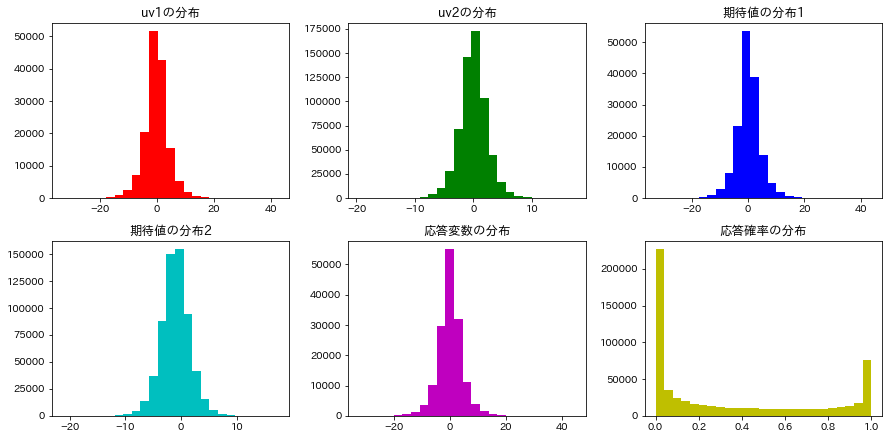

In [14]:
#潜在変数ごとのヒストグラム
dt = [uv1, uv2, mu1, mu2, y1, Prob]
fig_range = np.append(np.array([np.min(uv1), np.min(uv2), np.min(mu1), np.min(mu2), np.min(y1), 0.0]), 
                      np.array([np.max(uv1), np.max(uv2), np.max(mu1), np.max(mu2), np.max(y1), 1.0])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["uv1の分布", "uv2の分布", "期待値の分布1", "期待値の分布2", "応答変数の分布", "応答確率の分布"]
fig = plt.figure(figsize=(12.5, 9.0))
for j in range(len(dt)):
    ax = fig.add_subplot(3, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [15]:
####Joint Embedding with Factorization Machineseを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm1(mu, mu_vec, Sigma, record_id1, record_id2, index_record1, index_record2, a, b, N, N1, N2):
    U = np.repeat(0.0, N)
    FA = norm.cdf(a, mu, Sigma)
    FB = norm.cdf(b, mu, Sigma)
    U[index_record1] = norm.ppf(np.random.uniform(0, 1, N1)*(FB-FA)[record_id1]+FA[record_id1], mu_vec[index_record1], Sigma)
    U[index_record2] = norm.ppf(np.random.uniform(0, 1, N2)*FA[record_id2], mu_vec[index_record2], Sigma)
    return U

def rtnorm2(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [16]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [127]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(100/keep)
iter = 0
disp = 10

In [128]:
##データの設定
#切断領域の定義
rho = 100.0
a = np.repeat(0.0, N)
b = np.repeat(rho, N)
flag = y_vec - (1-y_vec)

#頻度を集計
d_freq = np.repeat(0, hh)
item_freq = np.repeat(0, item)
element_freq = np.repeat(0, element)
for i in range(hh):
    d_freq[i] = np.sum(m[d_list2[i]])
for i in range(item):
    item_freq[i] = np.sum(m[item_list2[i]])
for i in range(element):
    element_freq[i] = np.sum(m[element_list2[i]])
NM = np.array([hhpt, M])
    
#レコードのインデックスを作成
record_long = np.repeat(np.arange(N), m)
record_long1 = np.repeat(np.arange(N), data[:, 0])
record_long2 = np.repeat(np.arange(N), data[:, 1])
index_record1 = np.array(np.where(y_vec==1)[0], dtype="int")
index_record2 = np.array(np.where(y_vec==0)[0], dtype="int")
long_dt = sparse.coo_matrix((np.repeat(1, M), (record_long, range(M))), shape=(N, M)).tocsr()
M1 = index_record1.shape[0]
M2 = index_record2.shape[0]

#特徴行列の割当インデックス
allocation_u = np.repeat(np.arange(k1), k2)
allocation_v = np.tile(np.arange(k2), k1)
allocation_omega = np.array([np.delete(np.arange(k3), j).tolist() for j in range(k3)])

In [129]:
##重みパラメータを定義
#ユーザーの重みパラメータ
pt = np.hstack((pt1[:, np.newaxis], np.array([np.sum(m[d_list2[i]]) for i in range(hh)], dtype="int")[:, np.newaxis]))
d_weight = pt / np.sum(pt, axis=1)[:, np.newaxis]

#アイテムの重みパラメータ
item_n = np.hstack((np.array([item_list2[i].shape[0] for i in range(item)])[:, np.newaxis],
                    np.array([np.sum(m[item_list2[i]]) for i in range(item)])[:, np.newaxis]))
item_weights = item_n / np.sum(item_n, axis=1)[:, np.newaxis]

#エレメントの重みパラメータ
element_n = np.hstack((np.array([element_list2[i].shape[0] for i in range(element)])[:, np.newaxis],
                    np.array([np.sum(m[element_list2[i]]) for i in range(element)])[:, np.newaxis]))
element_weights = element_n / np.sum(element_n, axis=1)[:, np.newaxis]

In [130]:
##事前分布の設定
#階層モデルの事前分布
V1 = 0.1 * np.diag(np.ones(k1))
V2 = 0.1 * np.diag(np.ones(k2))
nu = 1
s01 = 0.1
v01 = 0.1

#モデルパラメータの事前分布
alpha1 = np.repeat(0.0, type_n)
alpha2 = np.array([0.0])
alpha_u = np.repeat(0.0, k1)
alpha_v = np.repeat(0.0, k2)
alpha_e = np.repeat(1.0, k3)
alpha_g = np.repeat(0.0, k1*k2)
Cov_e = np.diag(np.repeat(0.1, k3))
inv_Cov_e = np.linalg.inv(Cov_e)
Cov_g = np.diag(np.repeat(0.1, k1*k2))
inv_Cov_g = np.linalg.inv(Cov_g)
tau = 100 
s02 = 1.0
v02 = 1.0

In [131]:
##パラメータの真値
#階層モデルの分散の真値
tau_u = taut_u.copy()
tau_v = taut_v.copy()
inv_tau_u = np.linalg.inv(tau_u)
Cov_u = Covt_u.copy()
Cov_v = Covt_v.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの真値
Sigma = Sigmat.copy()
beta = betat.copy()
beta_u = betat_u.copy()
beta_v = betat_v.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_e = thetat_e.copy()
omega11 = omegat11.copy()
omega12 = omegat12.copy()
omega2 = omegat2.copy()

In [132]:
##モデルの期待値
#ランダム効果のパラメータを拡張
beta_company1 = beta_u[d_id, 0]; beta_company2 = beta_u[d_long, 1]
beta_item2 = beta_v[item_long]

#特徴行列のパラメータを拡張
theta_company1 = theta_u[d_id, ]; theta_company2 = theta_u[d_long, ]
theta_item = theta_v[item_long, ]
theta_item1 = theta_v[item_long1, ]; theta_item2 = theta_v[item_long2, ] 
theta_element = theta_e[element_long, ]
theta_element1 = theta_element[element_long1, ]; theta_element2 = theta_e[element_long2, ] 

#タッカー分解の期待値
uv_long1 = np.repeat(0.0, N)
uv2 = np.repeat(0.0, N)
for j in range(k3):
    uv_long1[index_greater] += np.dot(np.dot(theta_u, omega11[:, :, j])[d_long1, ] * 
                                      theta_item1 * theta_element1[:, j][:, np.newaxis], vec_k2)
    uv_long1[index_lesser] += np.dot(np.dot(theta_u, omega12[:, :, j])[d_long2, ] *
                                     theta_item2 * theta_element2[:, j][:, np.newaxis], vec_k2)
    uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_long, ] * theta_item * theta_element[:, j][:, np.newaxis], vec_k2)
uv1 = np.dot(sparse.csr_matrix(uv_long1), Zi).toarray().reshape(-1)

#モデルの線形結合
mut1 = beta[0] + beta_company1 + uv1
mut2 = beta[1] + beta_company2 + beta_item2 + uv2

In [156]:
##パラメータの初期値
#階層モデルの分散の初期値
tau_u = np.diag(np.array([0.25, 0.25]))
tau_v = np.array([0.25])
inv_tau_u = np.linalg.inv(tau_u)
Cov_u = np.diag(np.repeat(0.2, k1))
Cov_v = np.diag(np.repeat(0.2, k2))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの初期値
Sigma = np.array([np.std(y1), 1.0])
beta = np.array([0.0, -0.25])
beta_u = np.random.multivariate_normal(alpha1, tau_u, hh)
beta_v = np.random.normal(alpha2, tau_v, item)
theta_u = np.random.multivariate_normal(alpha_u, Cov_u, hh)
theta_v = np.random.multivariate_normal(alpha_v, Cov_v, item)
theta_e = np.random.multivariate_normal(alpha_e, Cov_e, element)
omega11 = np.random.normal(0, 0.1, k1*k2*k3).reshape(k1, k2, k3)
omega12 = np.random.normal(0, 0.1, k1*k2*k3).reshape(k1, k2, k3)
omega2 = np.random.normal(0, 0.1, k1*k2*k3).reshape(k1, k2, k3)

In [157]:
##モデルの期待値
#ランダム効果のパラメータを拡張
beta_company1 = beta_u[d_id, 0]; beta_company2 = beta_u[d_long, 1]
beta_item2 = beta_v[item_long]

#特徴行列のパラメータを拡張
theta_company1 = theta_u[d_id, ]; theta_company2 = theta_u[d_long, ]
theta_item = theta_v[item_long, ]
theta_item1 = theta_v[item_long1, ]; theta_item2 = theta_v[item_long2, ] 
theta_element = theta_e[element_long, ]
theta_element1 = theta_element[element_long1, ]; theta_element2 = theta_e[element_long2, ] 

#タッカー分解の期待値
uv_long1 = np.repeat(0.0, N)
uv2 = np.repeat(0.0, N)
for j in range(k3):
    uv_long1[index_greater] += np.dot(np.dot(theta_u, omega11[:, :, j])[d_long1, ] * 
                                      theta_item1 * theta_element1[:, j][:, np.newaxis], vec_k2)
    uv_long1[index_lesser] += np.dot(np.dot(theta_u, omega12[:, :, j])[d_long2, ] *
                                     theta_item2 * theta_element2[:, j][:, np.newaxis], vec_k2)
    uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_long, ] * theta_item * theta_element[:, j][:, np.newaxis], vec_k2)
uv1 = np.dot(sparse.csr_matrix(uv_long1), Zi).toarray().reshape(-1)

#モデルの線形結合
mu1 = beta[0] + beta_company1 + uv1
mu2 = beta[1] + beta_company2 + beta_item2 + uv2

In [158]:
##パラメータの格納用配列
#階層モデルのパラメータの格納用配列
TAU_U = np.zeros((int(R/keep), type_n))
TAU_E = np.repeat(0.0, int(R/keep))
COV_U = np.zeros((k1, k1, int(R/keep)))
COV_V = np.zeros((k2, k2, int(R/keep)))
COV_E = np.zeros((k3, k3, int(R/keep)))

#モデルパラメータの格納用配列
BETA = np.zeros((int(R/keep), type_n))
BETA_U = np.zeros((hh, type_n, int(R/keep)))
BETA_V = np.zeros((int(R/keep), item))
THETA_U = np.zeros((hh, k1, int(R/keep)))
THETA_V = np.zeros((item, k2, int(R/keep)))
THETA_E = np.zeros((element, k3, int(R/keep)))
OMEGA11 = np.zeros((k1, k2, k3, int(R/keep)))
OMEGA12 = np.zeros((k1, k2, k3, int(R/keep)))
OMEGA2 = np.zeros((k1, k2, k3, int(R/keep)))

In [159]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
Prob = np.sum(y2)/M
LLst1 = np.sum(scipy.stats.norm.logpdf(y1, np.mean(y1), np.std(y1)))
LLst2 = np.sum(y2*np.log(Prob) + (m-y2)*np.log(1-Prob))
LLst = LLst1 + LLst2
print(np.round([LLst1, LLst2, LLst], 1))

#真値での対数尤度
Prob = norm.cdf(mut2, 0, Sigmat[1])
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest1 = np.sum(scipy.stats.norm.logpdf(y1, mut1, Sigmat[0]))
LLbest2 = np.sum(y2*np.log(Prob) + (m-y2)*np.log(1-Prob))
LLbest = LLbest1 + LLbest2
print(np.round([LLbest1, LLbest2, LLbest], 1))

[  -432501.9 -12164652.  -12597153.9]
[ -108638.2 -4914655.1 -5023293.3]


In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##切断正規分布から潜在効用を生成
    #モデルの期待値
    mu2 = beta[1] + beta_company2 + beta_item2 + uv2
    mu_vec = mu2[record_long]

    #潜在効用を生成
    u_vec = rtnorm1(mu2, mu_vec, Sigma[1], record_long1, record_long2, index_record1, index_record2, a, b, M, M1, M2)
    index_inf = np.array(np.where(np.isinf(u_vec)==True)[0], dtype="int")
    g = index_inf.shape[0]
    u_vec[index_inf] = y_vec[index_inf]*rtnorm2(0, Sigma[1], 0, 1, g) + (1-y_vec[index_inf])*rtnorm2(0, Sigma[1], 0, 1, g)
    U = np.dot(long_dt, sparse.csr_matrix(u_vec).T).toarray().reshape(-1)


    ##モデルの期待値パラメータをサンプリング
    #重み付きパラメータを定義
    beta_company_w = m*beta_company2
    beta_item_w = m*beta_item2
    uv_w = m*uv2

    #モデル誤差を定義
    Sigma_sq = np.power(Sigma, 2)
    er_y1 = y1 - beta_company1 - uv1
    er_y2 = U - beta_company_w - beta_item_w - uv_w

    #正規分布から期待値をサンプリング
    weights = np.power(tau, 2) / (Sigma_sq/NM + np.power(tau, 2))
    mu_par = weights * np.array([np.mean(er_y1), np.sum(er_y2)/M])
    beta = np.random.normal(mu_par, weights*Sigma_sq/NM)


    ##ユーザーランダム効果をサンプリング
    #モデル誤差を定義
    tau_sq = np.diag(tau_u)
    er_y1 = y1 - beta[0] - uv1
    er_y2 = U - m*beta[1] - beta_item_w - uv_w

    #事後分布のパラメータをサンプリング
    for i in range(hh):
        index1 = d_list1[i]; index2 = d_list2[i]
        weights = tau_sq / (Sigma_sq/pt[i, ] + tau_sq)
        beta_par = np.array([np.mean(er_y1[index1]), np.sum(er_y2[index2])/pt[i, 1]])
        beta_u[i, ] = np.random.normal(beta_par, weights*Sigma_sq/pt[i, ])

    #パラメータを更新
    beta_company1 = beta_u[d_id, 0]; beta_company2 = beta_u[d_long, 1]
    beta_company_w = m*beta_company2


    ##アイテムランダム効果をサンプリング
    #モデル誤差を定義
    er_y2 = U - m*beta[1] - beta_company_w - uv_w

    #事後分布のパラメータをサンプリング
    for i in range(item):
        index = item_list2[i]
        weights = np.power(tau_v, 2) / (Sigma_sq[1]/item_n[i, 1] + np.power(tau_v, 2))
        beta_par = np.sum(er_y2[index])/item_n[i, 1]
        beta_v[i] = np.random.normal(beta_par, weights*Sigma_sq[1]/item_n[i, 1])

    #パラメータを更新
    beta_item2 = beta_v[item_long, ]
    beta_item_w = m*beta_item2


    ##ユーザー特徴行列をサンプリング
    #モデル誤差を定義
    er_y1 = y1 - beta[0] - beta_company1
    er_y2 = U - m*beta[1] - beta_company_w - beta_item_w

    #新しい入力変数を生成
    ar1 = np.zeros((N, k1))
    X2 = np.zeros((N, k1))
    for j in range(k3):
        ar1[index_greater, ] += np.dot(theta_v, omega11[:, :, j].T)[item_long1, ] * theta_element1[:, j][:, np.newaxis]
        ar1[index_lesser, ] += np.dot(theta_v, omega12[:, :, j].T)[item_long2, ] * theta_element2[:, j][:, np.newaxis]
        X2 += np.dot(theta_v, omega2[:, :, j].T)[item_long, ] * theta_element[:, j][:, np.newaxis]
    uv_long1 = np.dot(ar1 * theta_company2, vec_k1)

    #レコード単位で和を取る
    X1 = np.dot(sparse.csr_matrix(ar1).T, Zi).T.toarray()
    uv1 = np.dot(sparse.csr_matrix(uv_long1), Zi).toarray().reshape(-1)

    #多変量正規分布から事後分布をサンプリング
    for i in range(hh):
        index1 = d_list1[i]; index2 = d_list2[i]
        er_y = np.append(er_y1[index1], er_y2[index2])
        x = np.vstack((X1[index1, ], X2[index2, ])); w = np.vstack((X1[index1, ], m[index2][:, np.newaxis]*X2[index2, ]))
        xy = np.dot(x.T, er_y)
        xxv = np.dot(w.T, x) + inv_Cov_u
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_u, alpha_u))
        theta_u[i, ] = np.random.multivariate_normal(theta_par, np.sum(Sigma_sq*d_weight[i, ])*inv_xxv,  1)

    #パラメータを更新
    theta_company1 = theta_u[d_id, ]; theta_company2 = theta_u[d_long, ]


    ##アイテム特徴行列をサンプリング
    #新しい入力変数を生成
    ar1 = np.zeros((N, k2))
    X2 = np.zeros((N, k2))
    for j in range(k3):
        ar1[index_greater, ] += np.dot(theta_u, omega11[:, :, j])[d_long1, ] * theta_element1[:, j][:, np.newaxis]
        ar1[index_lesser, ] += np.dot(theta_u, omega12[:, :, j])[d_long2, ] * theta_element2[:, j][:, np.newaxis]
        X2 += np.dot(theta_u, omega2[:, :, j])[d_long, ] * theta_element[:, j][:, np.newaxis]
    uv_long1 = np.dot(ar1 * theta_item, vec_k1)
    ar1_T = ar1.T

    #スパース行列を定義
    sparse_ar1 = sparse.csr_matrix(ar1_T)
    sparse_uv1 = sparse.csr_matrix(uv_long1)

    #アイテムごとに特徴ベクトルをサンプリング
    for i in range(item):
        #インデックスの定義
        index1 = item_list1[i]; index2 = item_list2[i]
        row0 = item_row0[i]; row1 = item_row1[i]

        #応答変数と入力変数を定義
        if item_flag[i]==1:
            u1 = er_y1[index1] - np.dot(sparse_uv1[:, row0], item_dt0[i]).toarray().reshape(-1)
            u2 = er_y2[index2] 
            er_y = np.append(u1, u2)
            x1 = np.dot(sparse_ar1[:, row1], item_dt1[i]).T.toarray()
            x2 = X2[index2, ]
            x = np.vstack((x1, x2)); w = np.vstack((x1, m[index2][:, np.newaxis]*x2))
        else:
            u1 = er_y1[index1] - np.dot(uv_long1[row0], item_dt0[i])
            u2 = er_y2[index2] 
            er_y = np.append(u1, u2)
            x1 = np.dot(ar1_T[:, row1], item_dt1[i]).T
            x2 = X2[index2, ]
            x = np.vstack((x1, x2)); w = np.vstack((x1, m[index2][:, np.newaxis]*x2))

        #多変量正規分布から事後分布をサンプリング
        xy = np.dot(x.T, er_y)
        xxv = np.dot(w.T, x) + inv_Cov_v
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_v, alpha_v))
        theta_v[i, ] = np.random.multivariate_normal(theta_par, np.sum(Sigma_sq*item_weights[i, ])*inv_xxv, 1)

    #パラメータを更新
    theta_item = theta_v[item_long, ]
    theta_item1 = theta_v[item_long1, ]; theta_item2 = theta_v[item_long2, ] 


    ##エレメント特徴行列をサンプリング
    #新しい入力変数を生成
    ar1 = np.zeros((N, k3))
    X2 = np.zeros((N, k3))
    for j in range(k3):
        ar1[index_greater, j] = np.dot(np.dot(theta_u, omega11[:, :, j])[d_long1, ] * theta_item1, vec_k2)
        ar1[index_lesser, j] = np.dot(np.dot(theta_u, omega12[:, :, j])[d_long2, ] * theta_item2, vec_k2)
        X2[:, j] = np.dot(np.dot(theta_u, omega2[:, :, j])[d_long, ] * theta_item, vec_k2)
    uv_long1 = np.dot(ar1 * theta_element, vec_k3)
    ar1_T = ar1.T

    #スパース行列を定義
    sparse_ar1 = sparse.csr_matrix(ar1_T)
    sparse_uv1 = sparse.csr_matrix(uv_long1)

    #エレメントごとに特徴ベクトルをサンプリング
    temp = np.zeros((element, k3))
    for i in range(element):
        #インデックスの定義
        index1 = element_list1[i]; index2 = element_list2[i]
        row0 = element_row0[i]; row1 = element_row1[i]

        #応答変数と入力変数を定義
        if element_flag[i]==1:
            u1 = er_y1[index1] - np.dot(sparse_uv1[:, row0], element_dt0[i]).toarray().reshape(-1)
            u2 = er_y2[index2] 
            er_y = np.append(u1, u2)
            x1 = np.dot(sparse_ar1[:, row1], element_dt1[i]).T.toarray()
            x2 = X2[index2, ]
            x = np.vstack((x1, x2)); w = np.vstack((x1, m[index2][:, np.newaxis]*x2))
        else:
            u1 = er_y1[index1] - np.dot(uv_long1[row0], element_dt0[i])
            u2 = er_y2[index2] 
            er_y = np.append(u1, u2)
            x1 = np.dot(ar1_T[:, row1], element_dt1[i]).T
            x2 = X2[index2, ]
            x = np.vstack((x1, x2)); w = np.vstack((x1, m[index2][:, np.newaxis]*x2))

        #多変量正規分布から事後分布をサンプリング
        xy = np.dot(x.T, er_y)
        xxv = np.dot(w.T, x) + inv_Cov_e
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_e, alpha_e))
        theta_e[i, ] = np.random.multivariate_normal(theta_par, np.sum(Sigma_sq*element_weights[i, ])*inv_xxv, 1)

    #パラメータを更新
    theta_element = theta_e[element_long, ]
    theta_element1 = theta_element[element_long1, ]; theta_element2 = theta_e[element_long2, ] 


    ##コアテンソルをサンプリング
    #モデル誤差を定義
    target_y1 = y1 - beta[0] - beta_company1
    target_y2 = U - m*beta[1] - beta_company_w - beta_item_w

    #タッカー分解の期待値を更新
    uv_deploy11 = np.zeros((N1, k3)); uv_deploy12 = np.zeros((N2, k3)) 
    uv_deploy2 = np.zeros((N, k3))
    for j in range(k3):
        uv_deploy11[:, j] = np.dot(np.dot(theta_u, omega11[:, :, j])[d_long1, ] * 
                                   theta_item1 * theta_element1[:, j][:, np.newaxis], vec_k2)
        uv_deploy12[:, j] = np.dot(np.dot(theta_u, omega12[:, :, j])[d_long2, ] * 
                                   theta_item2 * theta_element2[:, j][:, np.newaxis], vec_k2)
        uv_deploy2[:, j] = np.dot(np.dot(theta_u, omega2[:, :, j])[d_long, ] * theta_item * theta_element[:, j][:, np.newaxis], vec_k2)
    theta_a1 = theta_u[:, allocation_u]; theta_a2 = theta_v[:, allocation_v]
    theta_deploy2 = theta_a1[d_long, ] * theta_a2[item_long, ]
    theta_deploy11 = theta_deploy2[index_greater, ]; theta_deploy12 = theta_deploy2[index_lesser, ]

    #スパース行列を定義
    sparse_uv11 = scipy.sparse.csr_matrix(uv_deploy11).T
    sparse_uv12 = scipy.sparse.csr_matrix(uv_deploy12).T
    sparse_deploy11 = scipy.sparse.csr_matrix(theta_deploy11).T
    sparse_deploy12 = scipy.sparse.csr_matrix(theta_deploy12).T
    sparse_element11 = scipy.sparse.csr_matrix(theta_element1).T
    sparse_element12 = scipy.sparse.csr_matrix(theta_element2).T

    for j in range(k3):
        #入力変数と応答変数を定義
        er_y11 = target_y1 - np.dot(np.dot(sparse_uv11[allocation_omega[j, ], ] , Zi1).T.toarray(), np.repeat(1, k3-1))
        er_y12 = target_y1 - np.dot(np.dot(sparse_uv12[allocation_omega[j, ], ] , Zi2).T.toarray(), np.repeat(1, k3-1))
        er_y2 = target_y2 - m*np.dot(uv_deploy2[:, allocation_omega[j, ]], np.repeat(1, k3-1))
        x11 = np.dot(sparse_deploy11.multiply(sparse_element11[j, ]), Zi1).T.toarray()
        x12 = np.dot(sparse_deploy12.multiply(sparse_element12[j, ]), Zi2).T.toarray()
        x2 = theta_deploy2 * theta_element[:, j][:, np.newaxis]; w2 = m[:, np.newaxis]*x2

        #多変量正規分布から事後分布をサンプリング
        xy11 = np.dot(x11.T, er_y11); xy12 = np.dot(x12.T, er_y12); xy2 = np.dot(x2.T, er_y2)
        xxv11 = np.dot(x11.T, x11) + inv_Cov_g; xxv12 = np.dot(x12.T, x12) + inv_Cov_g; xxv2 = np.dot(w2.T, x2) + inv_Cov_g
        inv_xxv11 = np.linalg.inv(xxv11); inv_xxv12 = np.linalg.inv(xxv12); inv_xxv2 = np.linalg.inv(xxv2)
        omega11[:, :, j] = np.random.multivariate_normal(np.dot(inv_xxv11, xy11), Sigma_sq[0]*inv_xxv11, 1).reshape(k1, k2)
        omega12[:, :, j] = np.random.multivariate_normal(np.dot(inv_xxv12, xy12), Sigma_sq[0]*inv_xxv12, 1).reshape(k1, k2)
        omega2[:, :, j] = np.random.multivariate_normal(np.dot(inv_xxv2, xy2), Sigma_sq[1]*inv_xxv2, 1).reshape(k1, k2)


    ##モデルの期待値
    #タッカー分解の期待値
    uv_long1 = np.repeat(0.0, N)
    uv2 = np.repeat(0.0, N)
    for j in range(k3):
        uv_long1[index_greater] += np.dot(np.dot(theta_u, omega11[:, :, j])[d_long1, ] * 
                                          theta_item1 * theta_element1[:, j][:, np.newaxis], vec_k2)
        uv_long1[index_lesser] += np.dot(np.dot(theta_u, omega12[:, :, j])[d_long2, ] *
                                         theta_item2 * theta_element2[:, j][:, np.newaxis], vec_k2)
        uv2 += np.dot(np.dot(theta_u, omega2[:, :, j])[d_long, ] * theta_item * theta_element[:, j][:, np.newaxis], vec_k2)
    uv1 = np.dot(sparse.csr_matrix(uv_long1), Zi).toarray().reshape(-1)

    #モデルの線形結合
    mu1 = beta[0] + beta_company1 + uv1
    mu2 = beta[1] + beta_company2 + beta_item2 + uv2


    ##モデルの標準偏差をサンプリング
    #逆ガンマ分布のパラメータ
    er1 = y1 - mu1
    s1 = np.dot(er1, er1) + s01
    v1 = hhpt + v01

    #パラメータをサンプリング
    Sigma[0] = np.sqrt(1/np.random.gamma(v1/2, 1/(s1/2), 1))

    ##ランダム効果の標準偏差をサンプリング
    #逆ガンマ分布のパラメータ
    er_u = beta_u - np.mean(beta_u, axis=0); er_v = beta_v - np.mean(beta_v)
    s11 = np.diag(np.dot(er_u.T, er_u)) + s01
    s12 = np.dot(er_v, er_v) + s01
    v11 = hh + v01; v12 = item + v01

    #パラメータをサンプリング
    tau_u = np.diag(1/np.random.gamma(v11/2, 1/(s11/2)))
    tau_v = np.sqrt(1/np.random.gamma(v12/2, 1/(s12/2), 1))

    ##特徴行列の分散共分散行列をサンプリング
    #逆ウィシャート分布のパラメータ
    er_u = theta_u - np.mean(theta_u, axis=0)
    er_v = theta_v - np.mean(theta_v, axis=0)
    IW_R1 = np.dot(er_u.T, er_u) + V1
    IW_R2 = np.dot(er_v.T, er_v) + V2
    Sn1 = hh + nu
    Sn2 = item + nu

    #パラメータをサンプリング
    Cov_u = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn1, IW_R1, 1)))
    Cov_v = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn2, IW_R2, 1)))
    inv_Cov_u = np.linalg.inv(Cov_u)
    inv_Cov_v = np.linalg.inv(Cov_v)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        #階層モデルのパラメータのサンプリング結果の格納
        mkeep = int(rp/keep)
        TAU_U[mkeep, ] = np.diag(tau_u)
        TAU_V[mkeep] = tau_v
        COV_U[:, :, mkeep] = Cov_u
        COV_V[:, :, mkeep] = Cov_v

        #モデルパラメータのサンプリング結果を格納
        SIGMA[mkeep, ] = Sigma
        BETA[mkeep, ] = beta
        BETA_U[:, :, mkeep] = beta_u
        BETA_V[mkeep, ] = beta_v
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_E[:, :, mkeep] = theta_e
        OMEGA11[:, :, :, mkeep] = omega11
        OMEGA12[:, :, :, mkeep] = omega12
        OMEGA2[:, :, :, mkeep] = omega2

    #対数尤度の更新とサンプリング結果を表示
    if rp%disp==0:
        #学習データの対数尤度を更新
        Prob = norm.cdf(mu2, 0, Sigma[1])
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
        LL1 = np.sum(scipy.stats.norm.logpdf(y1, mu1, Sigma[0]))
        LL2 = np.sum(y2*np.log(Prob) + (m-y2)*np.log(1-Prob))
        LL = LL1 + LL2

        #サンプリング結果の表示
        print(rp)
        print(np.round([LL1, LL2, LL, LLst1, LLst2, LLst, LLbest1, LLbest2, LLbest], 1))
        print(np.round(np.append(Sigma, Sigmat), 1))

0
[  -427069.1 -10473271.4 -10900340.5   -432501.9 -12164652.  -12597153.9
   -108638.2  -4914655.1  -5023293.3]
[4.2 1.  0.5 1. ]
